# Pendahuluan

Nurul Jannah (personal.nuruljannah@gmail.com)

Berikut Pemodelan Jaringan Syaraf Tiruan untuk Klasifikasi Teks yang saya susun untuk memenuhi syarat lulus kelas 'Belajar Pengembangan Machine Learning'.

# Mengakses Dataset

Untuk mengunduh dataset dari kaggle maka pertama-tama kita perlu menghubungkan Google Colaboratory dengan Kaggle menggunakan Kaggle API.

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"kynuuu","key":"bb4723de81bdc3c6bbddaf30ec71d7c8"}'}

In [3]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets list

ref                                                           title                                              size  lastUpdated          downloadCount  
------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                   Reddit Vaccine Myths                              233KB  2021-07-06 12:04:44           8877  
crowww/a-large-scale-fish-dataset                             A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           5442  
imsparsh/musicnet-dataset                                     MusicNet Dataset                                   22GB  2021-02-18 14:12:19           1951  
dhruvildave/wikibooks-dataset                                 Wikibooks Dataset                                   2GB  2021-07-03 18:37:20           2357  
promptcloud/careerbuilder-job-listing-2020                    Ca

# Mengunduh Dataset

Dataset yang akan digunakan pada pemodelan jaringan syaraf tiruan untuk klasifikasi teks ini adalah IMDB Dataset of 50k Movie Reviews. Dataset ini terdiri dari 50000 review film beserta sentiment-nya yang terdiri dari dua label yaitu positif dan negatif. Sehingga pada pemodelan ini akan dilakukan _binary text clasification_. Tujuan pemodelan ini adalah agar mesin dapat membedakan antara review positif dan negatif.

In [7]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

imdb-dataset-of-50k-movie-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


# Mengekstrak file zip

Mengekstrak dataset yang telah diunduh sebelumnya.

In [8]:
import os
import zipfile

local_zip = '/content/imdb-dataset-of-50k-movie-reviews.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/imdb-dataset')
zip_ref.close()

In [9]:
base_dir = ('/content/imdb-dataset')
os.listdir(base_dir)

['IMDB Dataset.csv']

# Load Dataset

Dataset yang telah diunduh dan diekstrak selanjutnya di load ke dalam bentuk dataframe agar lebih mudah di proses.

In [10]:
import pandas as pd

df = pd.read_csv('/content/imdb-dataset/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Karena label pada dataset berupa data kategorik, maka perlu dilakukan proses _one-hot-encoding_ seperti dibawah ini. Kemudian buat dataframe baru yang terdiri dari review dan label yang telah diubah ke bentuk dummy.

In [11]:
sentiment = pd.get_dummies(df.sentiment)
df_baru = pd.concat([df['review'], sentiment], axis=1)
df_baru

,review,negative,positive
0,One of the other reviewers has mentioned that ...,0,1
1,A wonderful little production. <br /><br />The...,0,1
2,I thought this was a wonderful way to spend ti...,0,1
3,Basically there's a family where a little boy ...,1,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",0,1
...,...,...,...
49995,I thought this movie did a down right good job...,0,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",1,0
49997,I am a Catholic taught in parochial elementary...,1,0
49998,I'm going to have to disagree with the previou...,1,0


In [12]:
len(df_baru)

50000

Selanjutnya nilai-nilai pada dataframe diubah ke dalam tipe data numpy array menggunakan atribut values agar dapat diproses oleh model. Kemudian data dibagi menjadi data training dan testing dengan rasio 80% untuk data training dan 20% untuk data testing.

In [13]:
from sklearn.model_selection import train_test_split

review = df_baru['review'].values
label = df_baru[['negative', 'positive']].values

review_train, review_test, label_train, label_test = train_test_split(review, label, test_size=0.2)

Tahap selanjutnya adalah mengubah setiap kata pada dataset ke dalam bilangan numerik dengan fungsi Tokenizer. Setelah tokenisasi selesai, konversi setiap sampel menjadi sequence.

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=500, oov_token='x')
tokenizer.fit_on_texts(review_train)
tokenizer.fit_on_texts(review_test)

sequence_train = tokenizer.texts_to_sequences(review_train)
sequence_test = tokenizer.texts_to_sequences(review_test)

padded_train = pad_sequences(sequence_train)
padded_test = pad_sequences(sequence_test)

Untuk arsitektur model digunakan layer Embedding dan LSTM.

In [15]:
import tensorflow as tf

model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
                             tf.keras.layers.LSTM(64),
                             #tf.keras.layers.GlobalAveragePooling1D(),
                             tf.keras.layers.Dense(128, activation='relu'),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dense(2, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Pada pemodelan ini digunakan fungsi callback untuk memberi tahu model agar berhenti melakukan pelatihan ketika akurasi telah mencapai 90%.

In [16]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.90):
      print('\nAkurasi telah mencapai 90%!')
      self.model.stop_training = True
    
callbacks = myCallback()

Terlihat di bawah ini model berhasil menghentikan pelatihan ketika telah mencapai akurasi 90% pada epoch ke 24 dari 50. Artinya kita telah menghemat waktu eksekusi 26 epoch.

In [17]:
hist = model.fit(
    padded_train,
    label_train,
    epochs=50,
    validation_data=(padded_test, label_test),
    verbose=2,
    callbacks=[callbacks])

Epoch 1/50
1250/1250 - 97s - loss: 0.4670 - accuracy: 0.7736 - val_loss: 0.4537 - val_accuracy: 0.7969
Epoch 2/50
1250/1250 - 94s - loss: 0.3857 - accuracy: 0.8310 - val_loss: 0.3716 - val_accuracy: 0.8403
Epoch 3/50
1250/1250 - 94s - loss: 0.3675 - accuracy: 0.8421 - val_loss: 0.3691 - val_accuracy: 0.8406
Epoch 4/50
1250/1250 - 94s - loss: 0.3674 - accuracy: 0.8446 - val_loss: 0.3460 - val_accuracy: 0.8465
Epoch 5/50
1250/1250 - 93s - loss: 0.3454 - accuracy: 0.8538 - val_loss: 0.3738 - val_accuracy: 0.8468
Epoch 6/50
1250/1250 - 93s - loss: 0.3379 - accuracy: 0.8572 - val_loss: 0.3590 - val_accuracy: 0.8393
Epoch 7/50
1250/1250 - 93s - loss: 0.3168 - accuracy: 0.8680 - val_loss: 0.3296 - val_accuracy: 0.8575
Epoch 8/50
1250/1250 - 93s - loss: 0.3087 - accuracy: 0.8697 - val_loss: 0.3409 - val_accuracy: 0.8612
Epoch 9/50
1250/1250 - 95s - loss: 0.3078 - accuracy: 0.8705 - val_loss: 0.3528 - val_accuracy: 0.8409
Epoch 10/50
1250/1250 - 95s - loss: 0.3011 - accuracy: 0.8750 - val_loss:

In [18]:
model.evaluate(padded_test, label_test)

313/313 [==============================] - 8s 24ms/step - loss: 0.3073 - accuracy: 0.8739


[0.307282954454422, 0.8738999962806702]

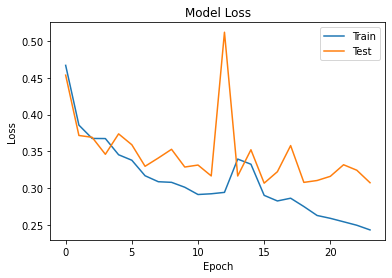

In [30]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Dari grafik di atas terlihat bahwa model dapat dilatih sedikit lebih lama karena tren loss dari kedua dataset masih berkurang selama epoch terakhir.

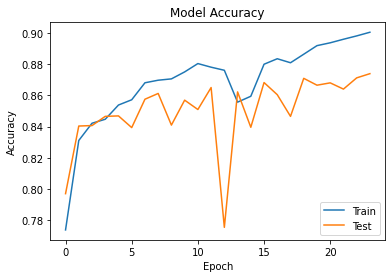

In [31]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

Berdasarkan grafik di atas terlihat bahwa model dapat dilatih sedikit lebih lama karena tren akurasi dari kedua dataset masih meningkat selama epoch terakhir. Terlihat juga bahwa kedua dataset memiliki kemampuan yang tidak jauh berbeda. 